# Lista 3 - Finanças Quantitativas e Gerenciamento de Risco

Vinicius Julião Ramos - 2018054630

## Questão 2

In [1]:
source("../utils/graficos.r")
source("../utils/funcoesAuxiliares.r");
source("../utils/model.r");
loadPackage("quantmod");
loadPackage("quadprog");
loadPackage('lpSolve');
library("tseries");
library("reshape2")
library("ggplot2")

options(scipen=999);
loadPackage("RCurl");
data <- getURL("http://www.dcc.ufmg.br/~arbex/portfolios/IBOV.csv", ssl.verifypeer=0L, followlocation=1L);
prices = read.csv(text = data, header = TRUE, sep = ",", stringsAsFactors = FALSE);
begin  = which(prices[,1] > 20190000)[1];
end    = which(prices[,1] > 20200000)[1];
os.prices = prices[end:nrow(prices), ];
is.prices = prices[begin:end, ];

## Questão 2A
### Passo 1:

Obter os retornos usando o método de Markowitz a partir do dados insample

In [2]:
# removendo as colunas 'Date' e 'IBOV'
insample.prices = is.prices[,3:ncol(is.prices)];
outsample.prices = os.prices[,3:ncol(os.prices)];

# calculo da matriz de retornos simples
insample.returns = apply(insample.prices, 2, function(x){diff(x)/x[-length(x)]} );
outsample.returns = apply(outsample.prices, 2, function(x){diff(x)/x[-length(x)]} );

# calculo do vetor de retornos esperados (mu) e matriz de covariancias (Sigma)
insample.mu = matrix(colMeans(insample.returns), nrow=1)
colnames(insample.mu) = colnames(insample.returns);
insample.Sigma = cov(insample.returns);


# Calculo dos portifolio por Markowitz
N = ncol(insample.returns)
markowitz.D = insample.Sigma; # Q do modelo
markowitz.d = rep(0, N);      # c do modelo

markowitz.A = matrix(c(rep(1, N),
        insample.mu,
        diag(N),
        -diag(N)),
        ncol = N,
        byrow = TRUE);

markowitz.b = c(1, 0.0001, rep(-0.15, 2*N));

markowitz.meq  = 1;

markowitz.result <- solve.QP(Dmat = markowitz.D, dvec = markowitz.d, Amat=t(markowitz.A), bvec=markowitz.b,
                            meq=markowitz.meq);

markowitz.weights = markowitz.result$solution

names(markowitz.weights) <- colnames(insample.prices)
markowitz.mu = as.numeric(crossprod(markowitz.weights, as.vector(insample.mu)))
markowitz.sigma2 = (markowitz.result$val)*2
markowitz.sigma = sqrt(markowitz.sigma2)

print(markowitz.weights)

      BOVA11        ABEV3        AZUL4        BTOW3        B3SA3        BBAS3 
-0.128297821  0.094513051 -0.049811930 -0.002387883 -0.135123154 -0.041617455 
       BBSE3        BRML3        BBDC3        BBDC4        BRAP4        BRKM5 
 0.081421086  0.006473257 -0.150000000  0.126904965  0.039863772  0.011568764 
       BRFS3       BPAC11        CRFB3        CCRO3        CMIG4        HGTX3 
 0.037796573 -0.010142985 -0.004665825 -0.009403152 -0.018038598  0.016595240 
       CIEL3        COGN3        CSAN3        CPFE3        CVCB3        CYRE3 
-0.001910725 -0.027501126  0.009529527  0.127049796 -0.009625067 -0.062617638 
       ECOR3        ELET3        ELET6        EMBR3        ENBR3        EGIE3 
 0.058404248 -0.146678752  0.150000000  0.127515548 -0.020202948  0.030370138 
       EQTL3        YDUQ3        FLRY3        GOAU4        GGBR4        GOLL4 
 0.074657313 -0.030839832  0.033632285  0.002721307 -0.079558633  0.013009613 
       HAPV3        HYPE3        IGTA3        GNDI3 

### Passo 2: Obter o IBOV para o Out-Sample

In [3]:
ibov <- c(os.prices$IBOV)
ibov <- ibov/ibov[1]


# Função para aplicar o portifólio com rebalanceamento diário
apply_portfolio <- function(weights, prices, returns){
    result <- prices[names(weights)]
    rownames(result) <- 1:nrow(prices)
    result[1,] <- weights
    
    for(i in 1:nrow(returns)){
#       rebalanceamento sem alterar a estratégia
        next_day <- (1+returns[i,])*result[i,]
        money <- sum(next_day)
        result[i+1,] <- weights * money
        
#       Buy and Hold  
#         result[i+1,]<- (1+returns[i,])*result[i,]
    }
    return (rowSums(result));
}

outsample.diff = as.data.frame(lapply(outsample.prices, diff, lag=1))
outsample.ret = outsample.diff / outsample.prices[- (length(outsample.prices)),]
outsample.ret.mult = 1 + outsample.ret
dias = nrow(outsample.ret)
daily_rebalance_strategy <- function(weight) {
  currentval = 1
  currentweight = weight
  val = c(currentval)
  for (i in 1 : (dias)) {
    currentweight = currentweight*outsample.ret.mult[i,]
    currentval = sum(currentweight)
    val = append(val, currentval)
  }
  return(val)
}

### Passo 3: Obtenção do portifólio via otimização do CVaR

In [4]:
# iniciando o modelo de maximização
model = initialiseModel();
model$setModelFilename('cvar.lp')
model$setTimeLimit(60000)
model$setDirection(1)

cvar.scenarios <- nrow(insample.prices) - 1
cvar.ativos <- ncol(insample.prices)
cvar.alpha <- 0.05

model$addVariable("V", 1)

for (i in 1 : cvar.scenarios) model$addVariable(paste0("d", i), -1/(cvar.alpha*cvar.scenarios), 0, Inf);
for (i in 1 : cvar.ativos) model$addVariable(paste0("w", i), 0, -0.15, 0.15)

cvar.wi = paste0("w", seq(1: cvar.ativos))

# ======= Contraints
for (i in 1 : cvar.scenarios){
  ri = as.numeric(unlist(insample.returns[i,]));
  elements = c("V", paste0("d", i), cvar.wi);
  values = c(-1, 1, ri);
  model$addConstraint(">=", 0, elements, values);
}

# \sum(mi(i)* wi) >= 0.0001
cvar.mu = as.numeric(unlist(insample.mu))
model$addConstraint(">=", 0.0001, cvar.wi, cvar.mu)

# soma de pesos igual a 1
values = rep(1,cvar.ativos)
model$addConstraint("=", 1, cvar.wi, values)

model$solve()
cvar.weights <- model$solution[(cvar.scenarios+2):(cvar.scenarios + cvar.ativos + 1)]
names(cvar.weights) <- colnames(insample.prices)
print(cvar.weights)

[1] 249

[1] 250

Optimisation model exported to file cvar.lp 
   in folder /home/vrjuliao/workfolder/BCC/financas-quantitativas/lista3

      BOVA11        ABEV3        AZUL4        BTOW3        B3SA3        BBAS3 
-0.049937533 -0.003058675  0.064031755 -0.009235122 -0.118727958 -0.150000000 
       BBSE3        BRML3        BBDC3        BBDC4        BRAP4        BRKM5 
-0.014967030  0.091199215 -0.073264784  0.050703027 -0.102249633  0.035355973 
       BRFS3       BPAC11        CRFB3        CCRO3        CMIG4        HGTX3 
 0.008804236  0.051750875 -0.130636569 -0.059296678 -0.148324693  0.021506357 
       CIEL3        COGN3        CSAN3        CPFE3        CVCB3        CYRE3 
-0.002095862 -0.087822433  0.058168166  0.150000000 -0.111599840 -0.078514953 
       ECOR3        ELET3        ELET6        EMBR3        ENBR3        EGIE3 
 0.106475831 -0.140790781  0.150000000  0.148348222  0.099995701  0.061379018 
       EQTL3        YDUQ3        FLRY3        GOAU4        GGBR4        GOLL4 
 0.063670265

### Passo 4: Plot dos portifólios em comparação com o IBOV

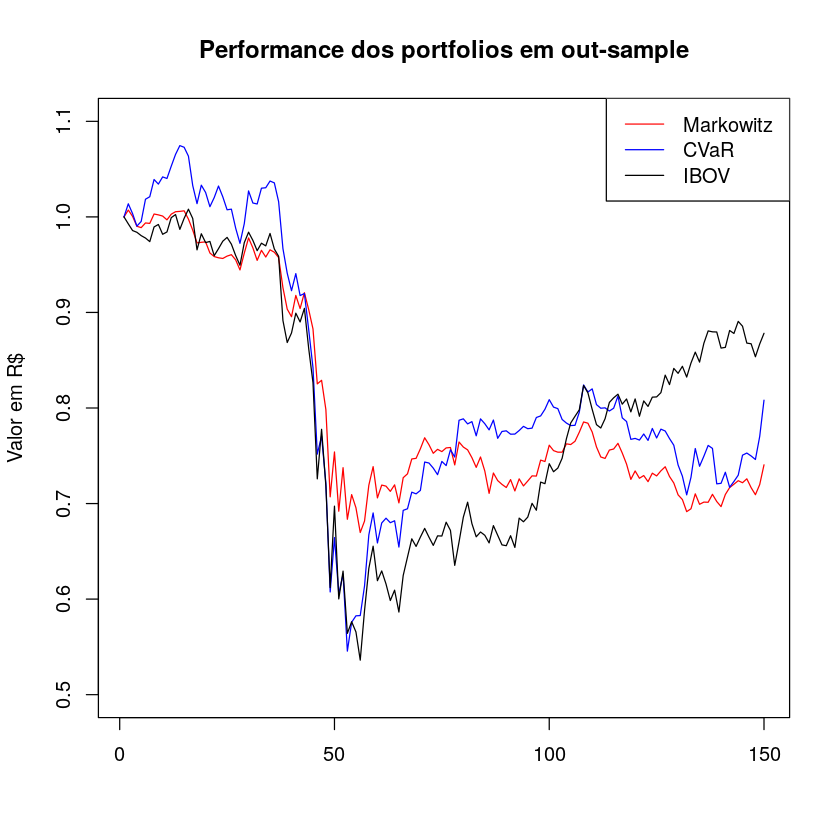

In [5]:
returns <- outsample.returns
rownames(returns) <- 1:nrow(outsample.returns)

markowitz.prices <- daily_rebalance_strategy(markowitz.weights)
cvar.prices <- daily_rebalance_strategy(cvar.weights)

# jpeg("Q2D.jpg", width = 500, height = 500)
plot(markowitz.prices, type="l", col="red", ylim=c(0.5,1.1), xlab="", ylab="")
lines(cvar.prices, col="blue")
lines(ibov, col="black")
title(main="Performance dos portfolios em out-sample",
      xlab=" ", ylab="Valor em R$")
legend("topright", legend=c("Markowitz", "CVaR", "IBOV"),
  col=c("red", "blue", "black"), lty=1, cex=1.)
# dev.off();

## Questão 2 B
Obter os stats de cada um dos modelos de forma separada:

### IBOV

In [6]:
# Retorno esperado

ibov.prices <- os.prices[c('IBOV')]
ibov.prices <- ibov.prices / ibov.prices[1,]
ibov.diff <- as.data.frame(lapply(ibov.prices, diff, lag=1))
ibov.returns <- ibov.diff / ibov.prices[-(length(ibov.prices)),]
ibov.mu <- colMeans(ibov.returns)

ibov.sigma <- sapply(ibov.returns, sd);

# Cvar
ibov.ret.list <- ibov.returns[[1]];
ibov.var <- quantile(ibov.ret.list, probs = 0.05)[[1]];
ibov.cvar.returns <- subset(ibov.returns, IBOV <= ibov.var);
ibov.cvar <- colMeans(ibov.cvar.returns);

# Sharpe ratio
ibov.sharperatio <- (ibov.mu - 0.0001) / ibov.sigma

# STARR ratio
ibov.starrratio <- (ibov.mu - 0.0001) / ibov.cvar

# Drawdown maximo
ibov.list <- ibov.prices[[1]]
ibov.maxdrawdown.sol <- maxdrawdown(ibov.list)
ibov.maxdrawdown <- ibov.maxdrawdown.sol$maxdrawdown / ibov.list[ibov.maxdrawdown.sol$from]


In [7]:
ibov.mu

IBOV 
-0.001493825

### Markowitz

In [8]:
n = 150;
markowitz.returns <- ((markowitz.prices[2:n] - markowitz.prices[1:(n-1)])/markowitz.prices[1:(n-1)])
# retorno esperado
markowitz.mu <- mean(markowitz.returns)
markowitz.sigma <- sd(markowitz.returns)

markowitz.var <- quantile(markowitz.returns, probs = 0.05)[[1]]
markowitz.cvar.ret <- markowitz.returns[markowitz.returns<= markowitz.var]
markowitz.cvar <- mean(markowitz.cvar.ret)

markowitz.sharperatio <- (markowitz.mu - 0.0001) / markowitz.sigma

markowitz.starrratio <- (markowitz.mu - 0.0001) / markowitz.cvar

markowitz.maxdrawdown.sol <- maxdrawdown(markowitz.prices)
markowitz.maxdrawdown <- markowitz.maxdrawdown.sol$maxdrawdown / markowitz.prices[markowitz.maxdrawdown.sol$from ]

### CVaR

In [9]:
# retornos
n = 150;
cvar.returns <- ((cvar.prices[2:n] - cvar.prices[1:(n-1)])/cvar.prices[1:(n-1)])
cvar.mu = mean(cvar.returns)

cvar.sigma <- sd(cvar.returns)

# Cvar
cvar.var <- quantile(cvar.returns, probs = 0.05)[[1]]
cvar.cvar.ret <- cvar.returns[cvar.returns<= cvar.var]
cvar.cvar <- mean(cvar.cvar.ret)

cvar.sharperatio = (cvar.mu - 0.0001) / cvar.sigma

cvar.starrratio <-(cvar.mu - 0.0001) / cvar.cvar

cvar.maxdrawdown.sol <- maxdrawdown(cvar.prices);
cvar.maxdrawdown <- cvar.maxdrawdown.sol$maxdrawdown / cvar.prices[cvar.maxdrawdown.sol$from ]

In [10]:
cvar.mu

[1] -0.0009419848

In [11]:
show_stats <- function(ret, sigma, CVAR, sharpe, starr, drawdown, name){
    cat("Portfolio: ", name,"\n")
    cat("Retorno Esperado: ", ret,"\n")
    cat("Desvio Padrão: ", sigma,"\n")
    cat("CVAR 5%: ", CVAR,"\n")
    cat("SharpeRatio: ", sharpe,"\n")
    cat("STARR ratio 5%: ", starr,"\n")
    cat("Drawdown máximo: ", drawdown,"\n")
}


show_stats(cvar.mu, cvar.sigma, cvar.cvar, cvar.sharperatio, cvar.starrratio, cvar.maxdrawdown, "CVaR")
cat("\n")
show_stats(markowitz.mu, markowitz.sigma, markowitz.cvar, markowitz.sharperatio, markowitz.starrratio, markowitz.maxdrawdown, "Markowitz")
cat("\n")
show_stats(ibov.mu, ibov.sigma, ibov.cvar, ibov.sharperatio, ibov.starrratio, ibov.maxdrawdown, "IBOV")

Portfolio:  CVaR 
Retorno Esperado:  -0.0009419848 
Desvio Padrão:  0.0307812 
CVAR 5%:  -0.08613844 
SharpeRatio:  -0.03385134 
STARR ratio 5%:  0.01209663 
Drawdown máximo:  0.4923055 

Portfolio:  Markowitz 
Retorno Esperado:  -0.001768637 
Desvio Padrão:  0.02201264 
CVAR 5%:  -0.06077244 
SharpeRatio:  -0.08488927 
STARR ratio 5%:  0.0307481 
Drawdown máximo:  0.3350466 

Portfolio:  IBOV 
Retorno Esperado:  -0.001493825 
Desvio Padrão:  0.03596902 
CVAR 5%:  -0.1078977 
SharpeRatio:  -0.04431104 
STARR ratio 5%:  0.01477163 
Drawdown máximo:  0.4681596 
